In [1]:
import argparse
import os.path as ops
import time
import sys
sys.path.append("./")

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from lanenet_model import lanenet
from lanenet_model import lanenet_postprocess
from local_utils.config_utils import parse_config_utils
from local_utils.log_util import init_logger

CFG = parse_config_utils.lanenet_cfg
LOG = init_logger.get_logger(log_file_name_prefix='lanenet_test')

In [2]:
def init_args():
    """

    :return:
    """
    parser = argparse.ArgumentParser()
    parser.add_argument('--image_path', type=str, help='The image path or the src image save dir')
    parser.add_argument('--weights_path', type=str, help='The model weights path')

    return parser.parse_args()


def args_str2bool(arg_value):
    """

    :param arg_value:
    :return:
    """
    if arg_value.lower() in ('yes', 'true', 't', 'y', '1'):
        return True

    elif arg_value.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Unsupported value encountered.')


def minmax_scale(input_arr):
    """

    :param input_arr:
    :return:
    """
    min_val = np.min(input_arr)
    max_val = np.max(input_arr)

    output_arr = (input_arr - min_val) * 255.0 / (max_val - min_val)

    return output_arr

In [3]:
def test_lanenet(image_path, weights_path):
    """

    :param image_path:
    :param weights_path:
    :return:
    """
    assert ops.exists(image_path), '{:s} not exist'.format(image_path)

    LOG.info('Start reading image and preprocessing')
    t_start = time.time()
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image_vis = image
    image = cv2.resize(image, (512, 256), interpolation=cv2.INTER_LINEAR)
    image = image / 127.5 - 1.0
    LOG.info('Image load complete, cost time: {:.5f}s'.format(time.time() - t_start))

    input_tensor = tf.placeholder(dtype=tf.float32, shape=[1, 256, 512, 3], name='input_tensor')

    net = lanenet.LaneNet(phase='test')
    binary_seg_ret, instance_seg_ret = net.inference(input_tensor=input_tensor, name='LaneNet')

    postprocessor = lanenet_postprocess.LaneNetPostProcessor()

    # Set sess configuration
    sess_config = tf.ConfigProto()
    sess_config.gpu_options.per_process_gpu_memory_fraction = CFG.GPU.GPU_MEMORY_FRACTION
    sess_config.gpu_options.allow_growth = CFG.GPU.TF_ALLOW_GROWTH
    sess_config.gpu_options.allocator_type = 'BFC'

    sess = tf.Session(config=sess_config)

    # define moving average version of the learned variables for eval
    with tf.variable_scope(name_or_scope='moving_avg'):
        variable_averages = tf.train.ExponentialMovingAverage(
            CFG.SOLVER.MOVING_AVE_DECAY)
        variables_to_restore = variable_averages.variables_to_restore()

    # define saver
    saver = tf.train.Saver(variables_to_restore)

    with sess.as_default():
        saver.restore(sess=sess, save_path=weights_path)

        t_start = time.time()
        loop_times = 500
        for i in range(loop_times):
            binary_seg_image, instance_seg_image = sess.run(
                [binary_seg_ret, instance_seg_ret],
                feed_dict={input_tensor: [image]}
            )
        t_cost = time.time() - t_start
        t_cost /= loop_times
        LOG.info('Single imgae inference cost time: {:.5f}s'.format(t_cost))

        postprocess_result = postprocessor.postprocess(
            binary_seg_result=binary_seg_image[0],
            instance_seg_result=instance_seg_image[0],
            source_image=image_vis
        )
        mask_image = postprocess_result['mask_image']

        for i in range(CFG.MODEL.EMBEDDING_FEATS_DIMS):
            instance_seg_image[0][:, :, i] = minmax_scale(instance_seg_image[0][:, :, i])
        embedding_image = np.array(instance_seg_image[0], np.uint8)

        plt.figure('mask_image')
        plt.imshow(mask_image[:, :, (2, 1, 0)])
        plt.figure('src_image')
        plt.imshow(image_vis[:, :, (2, 1, 0)])
        plt.figure('instance_image')
        plt.imshow(embedding_image[:, :, (2, 1, 0)])
        plt.figure('binary_image')
        plt.imshow(binary_seg_image[0] * 255, cmap='gray')
        plt.show()

    sess.close()

    return


In [4]:
#args = init_args()

In [5]:
weights_path="/home/ubuntu/data/BiseNetV2_LaneNet_Tusimple_Model_Weights/tusimple_lanenet.ckpt"
#image_path="./data/tusimple_test_image/0.jpg"
image_path="/home/ubuntu/data/MCR/MCRApp/20200716103303img/image_and_sensor_20200716104008290.jpg"

2020-08-31 09:35:42.492 | INFO     | __main__:test_lanenet:10 - Start reading image and preprocessing
2020-08-31 09:35:42.505 | INFO     | __main__:test_lanenet:16 - Image load complete, cost time: 0.01058s



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


W0831 09:35:43.175847 2456 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use keras.layers.batch_normalization instead.


W0831 09:35:43.182255 2456 deprecation.py:323] From /home/ubuntu/git/LaneNet_eval/semantic_segmentation_zoo/cnn_basenet.py:352: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.batch_normalization instead.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0831 09:35:45.509687 2456 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /home/ubuntu/data/BiseNetV2_LaneNet_Tusimple_Model_Weights/tusimple_lanenet.ckpt


I0831 09:35:45.512177 2456 saver.py:1270] Restoring parameters from /home/ubuntu/data/BiseNetV2_LaneNet_Tusimple_Model_Weights/tusimple_lanenet.ckpt
2020-08-31 09:35:57.755 | INFO     | __main__:test_lanenet:54 - Single imgae inference cost time: 0.02267s


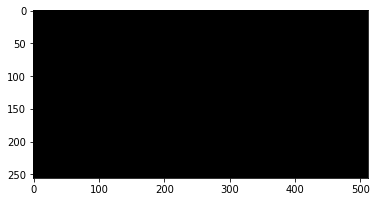

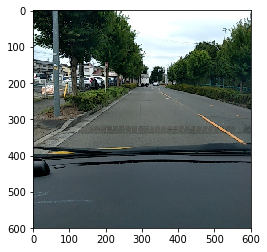

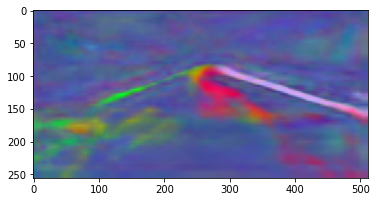

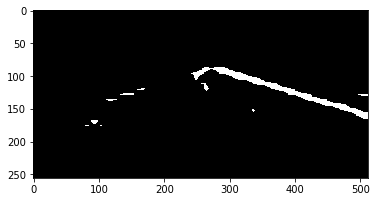

In [6]:
test_lanenet(image_path, weights_path)